In [1]:
import random
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('../data/crx.data', header=None)
varname = [f"A{s}" for s in range(1, 17)]
data.columns = varname
data = data.replace("?", np.nan)
data["A2"] = data["A2"].astype("float")
data["A14"] = data["A14"].astype("float")
data["A16"] = data["A16"].map({"+": 1, "-": 0})
data.rename(columns={"A16":"target"}, inplace=True)
random.seed(37)
values = list(set([random.randint(0, len(data)) for p in range(0, 100)]))
data.loc[values, ["A3", "A8", "A9", "A10"]] = np.nan
data.to_csv('../data/credit_approval_uci.csv', index=False)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
data = pd.read_csv('../data/credit_approval_uci.csv')

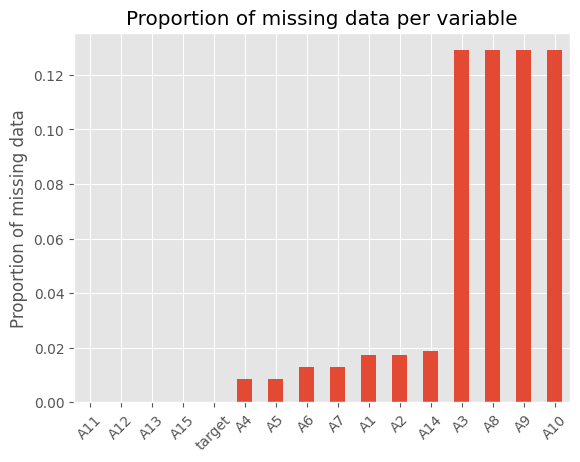

In [5]:
with plt.style.context('ggplot'):
    data.isnull().mean().sort_values(ascending=True).plot.bar(rot=45)
    plt.ylabel("Proportion of missing data")
    plt.title("Proportion of missing data per variable")

In [6]:
data_cca = data.dropna()

In [7]:
print(f"Total number of observations: {len(data)}")
print(f"Number of observations without missing data: {len(data_cca)}")

Total number of observations: 690
Number of observations without missing data: 570


In [8]:
from feature_engine.imputation import DropMissingData
cca = DropMissingData(variables=None, missing_only=True)
cca.fit(data)
print(cca.variables_)
data_cca = cca.transform(data)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A14']


## Performing mean or median imputation

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import MeanMedianImputer

In [10]:
data = pd.read_csv('../data/credit_approval_uci.csv')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target',
                                                              axis='columns'),
                                                    data['target'],
                                                    test_size=.3,
                                                    random_state=39)

In [12]:
numeric_vars = X_train.select_dtypes(exclude='O').columns.to_list()
numeric_vars

['A2', 'A3', 'A8', 'A11', 'A14', 'A15']

In [13]:
median_values = X_train[numeric_vars].median().to_dict()
median_values

{'A2': 28.71, 'A3': 2.9375, 'A8': 1.0, 'A11': 0.0, 'A14': 160.0, 'A15': 5.0}

In [14]:
for df in [X_train, X_test]:
# unable to modify X_train and X_test
# because df pointer to different address
#     df = df.fillna(value=median_values)
    df.fillna(value=median_values, inplace=True)
# equivalent to following codes
# X_train = X_train.fillna(value=median_values)
# X_test = X_test.fillna(value=median_values)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target',
                                                              axis='columns'),
                                                    data['target'],
                                                    test_size=.3,
                                                    random_state=39)

In [16]:
remaining_vars = [var for var in X_test.columns if var not in numeric_vars]
remaining_vars

['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']

In [17]:
imputer = SimpleImputer(strategy='median')

In [18]:
ct = ColumnTransformer([('imputer', imputer, numeric_vars)],
                       remainder='passthrough')

In [19]:
ct.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('imputer', SimpleImputer(strategy='median'),
                                 ['A2', 'A3', 'A8', 'A11', 'A14', 'A15'])])

In [20]:
ct.named_transformers_.imputer.statistics_

array([ 28.71  ,   2.9375,   1.    ,   0.    , 160.    ,   5.    ])

In [21]:
# warning: unable to perform median imputation
# for df in [X_train, X_test]:
#     df = ct.transform(df)
# return NumPy arrays
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

In [22]:
X_train = pd.DataFrame(X_train, columns=numeric_vars + remaining_vars)
X_train

,A2,A3,A8,A11,A14,A15,A1,A4,A5,A6,A7,A9,A10,A12,A13
0,25.67,12.5,1.21,67.0,140.0,258.0,b,u,g,cc,v,t,t,t,g
1,19.17,5.415,0.29,0.0,80.0,484.0,a,u,g,i,h,f,f,f,g
2,23.92,2.9375,1.0,0.0,100.0,0.0,b,u,g,c,v,NaN,NaN,f,g
3,32.08,2.9375,1.0,0.0,120.0,0.0,b,y,p,cc,v,NaN,NaN,t,g
4,20.83,0.5,1.0,0.0,260.0,0.0,a,y,p,e,dd,f,f,f,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,48.5,4.25,0.125,0.0,225.0,0.0,b,u,g,m,v,t,f,t,g
479,26.67,2.9375,1.0,1.0,120.0,0.0,b,u,g,cc,v,NaN,NaN,t,g
480,28.92,15.0,5.335,11.0,0.0,2283.0,b,u,g,c,h,t,t,f,g
481,54.83,15.5,0.0,20.0,152.0,130.0,b,u,g,e,z,t,t,f,g


In [23]:
X_test = pd.DataFrame(X_test, columns=numeric_vars + remaining_vars)
X_test

,A2,A3,A8,A11,A14,A15,A1,A4,A5,A6,A7,A9,A10,A12,A13
0,22.5,11.0,3.0,0.0,268.0,0.0,a,y,p,q,v,t,f,t,g
1,19.33,10.915,0.585,2.0,200.0,7.0,b,u,g,c,bb,f,t,t,g
2,28.17,2.9375,1.0,0.0,260.0,1004.0,NaN,u,g,aa,v,NaN,NaN,f,g
3,31.83,2.5,7.5,0.0,523.0,0.0,b,u,g,aa,v,t,f,t,g
4,20.67,0.415,0.125,0.0,0.0,44.0,b,u,g,c,v,f,f,f,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,29.83,3.5,0.165,0.0,216.0,0.0,b,u,g,c,v,f,f,f,g
203,30.67,2.5,2.25,0.0,340.0,0.0,b,u,g,cc,h,f,f,t,s
204,25.42,1.125,1.29,2.0,200.0,0.0,a,u,g,q,v,t,t,f,g
205,56.75,12.25,1.25,4.0,200.0,0.0,b,u,g,m,v,t,t,t,g


In [24]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target',
                                                              axis='columns'),
                                                    data['target'],
                                                    test_size=.3,
                                                    random_state=39)

In [25]:
imputer = MeanMedianImputer(imputation_method='median', variables=numeric_vars)

In [26]:
imputer.fit(X_train)

MeanMedianImputer(variables=['A2', 'A3', 'A8', 'A11', 'A14', 'A15'])

In [27]:
imputer.imputer_dict_

{'A2': 28.71, 'A3': 2.9375, 'A8': 1.0, 'A11': 0.0, 'A14': 160.0, 'A15': 5.0}

In [28]:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [29]:
print(X_train[numeric_vars].isnull().any().any())
print(X_test[numeric_vars].isnull().any().any())

False
False


## Imputing categorical variables

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import CategoricalImputer

data = pd.read_csv('../data/credit_approval_uci.csv')

X_train, X_test, y_train, y_test = train_test_split(data.drop('target',
                                                              axis='columns'),
                                                    data['target'],
                                                    test_size=.3,
                                                    random_state=37)
# using pandas
categorical_vars = X_train.select_dtypes(include='O').columns.to_list()
# important: iloc[0]
frequent_values = X_train[categorical_vars].mode().iloc[0].to_dict()
print(frequent_values)

X_train = X_train.fillna(value=frequent_values)
X_test = X_test.fillna(value=frequent_values)
print(X_train[categorical_vars].isnull().any().any())
print(X_test[categorical_vars].isnull().any().any())

# Imputation with a string
X_train, X_test, y_train, y_test = train_test_split(data.drop('target',
                                                              axis='columns'),
                                                    data['target'],
                                                    test_size=.3,
                                                    random_state=37)
imputation_dict = {var: 'no_data' for var in categorical_vars}
X_train = X_train.fillna(value=imputation_dict)
X_test = X_test.fillna(value=imputation_dict)
print(X_train['A1'].value_counts())

# using scikit-learn
X_train, X_test, y_train, y_test = train_test_split(data.drop('target',
                                                              axis='columns'),
                                                    data['target'],
                                                    test_size=.3,
                                                    random_state=37)

remaining_vars = [
    var for var in X_train.columns if var not in categorical_vars
]

imputation_dict = {var: 'not_data' for var in categorical_vars}
imputer = SimpleImputer(strategy='most_frequent')

ct = ColumnTransformer([('Imputer', imputer, categorical_vars)],
                       remainder='passthrough')

ct.fit(X_train)
# this string "Imputer" here must be identical to the string 'Imputer' in ColumnTransformer
print(ct.named_transformers_.Imputer.statistics_)

X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

X_train = pd.DataFrame(X_train, columns=categorical_vars + remaining_vars)
print(X_train[categorical_vars].isnull().any().any())

# using feature-engine
X_train, X_test, y_train, y_test = train_test_split(data.drop('target',
                                                              axis='columns'),
                                                    data['target'],
                                                    test_size=.3,
                                                    random_state=37)

imputer = CategoricalImputer(imputation_method='frequent', variables=categorical_vars)

imputer.fit(X_train)

print(imputer.imputer_dict_)

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)
print(X_train[categorical_vars].isnull().any().any())
print(X_test[categorical_vars].isnull().any().any())

{'A1': 'b', 'A4': 'u', 'A5': 'g', 'A6': 'c', 'A7': 'v', 'A9': 't', 'A10': 'f', 'A12': 'f', 'A13': 'g'}
False
False
b          332
a          144
no_data      7
Name: A1, dtype: int64
['b' 'u' 'g' 'c' 'v' 't' 'f' 'f' 'g']
False
{'A1': 'b', 'A4': 'u', 'A5': 'g', 'A6': 'c', 'A7': 'v', 'A9': 't', 'A10': 'f', 'A12': 'f', 'A13': 'g'}
False
False
